Ep 100, ε=0.100, P&L=5646.65
Ep 200, ε=0.100, P&L=4539.17
Ep 300, ε=0.100, P&L=5405.72
Ep 400, ε=0.100, P&L=8880.89
Ep 500, ε=0.100, P&L=10170.24
Ep 600, ε=0.100, P&L=7702.72
Ep 700, ε=0.100, P&L=9784.96
Ep 800, ε=0.100, P&L=12210.41
Ep 900, ε=0.100, P&L=7759.44
Ep 1000, ε=0.100, P&L=10475.97
Ep 1100, ε=0.100, P&L=10757.98
Ep 1200, ε=0.100, P&L=8864.78
Ep 1300, ε=0.100, P&L=6387.10
Ep 1400, ε=0.100, P&L=8418.78
Ep 1500, ε=0.100, P&L=9262.52
Ep 1600, ε=0.100, P&L=8993.95
Ep 1700, ε=0.100, P&L=13197.73
Ep 1800, ε=0.100, P&L=9097.27
Ep 1900, ε=0.100, P&L=7941.30
Ep 2000, ε=0.100, P&L=6968.25


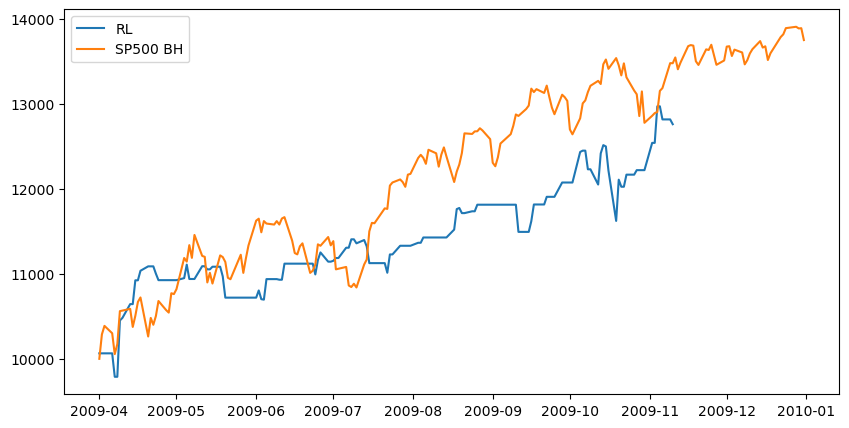

Final RL value: 12759.01
Final SP500: 13748.34
Diff: -989.32 (-7.20%)


In [1]:
# rl_rotation_single_capital.py
# A full RL pipeline: train on 2017–2018, test on 2019, single-capital rotation across 6 stocks vs. SP500

import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from datetime import datetime
from collections import deque

# --------------------------- CONFIG ---------------------------------
WINDOW      = 30
INIT_CASH   = 10_000
TRAIN_START = "2007-10-01"
TRAIN_END   = "2009-03-31"
TEST_START  = "2009-04-01"
TEST_END    = "2009-12-31"
TICKERS     = ["AAPL","MSFT","AMZN","GOOGL","NVDA"]
DATA_FOLDER = Path("data")  # CSVs named e.g. aapl_us_d.csv, etc.

# ----------------------- DATA LOADING -------------------------------
def read_local_csv(ticker: str) -> pd.DataFrame:
    fp = DATA_FOLDER / f"{ticker.lower()}_us_d.csv"
    df = pd.read_csv(fp, parse_dates=["Date"]).set_index("Date").sort_index()
    price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    df["return"] = df[price_col].pct_change().fillna(0)
    df["ticker"] = ticker
    return df


def build_panel(tickers, start, end):
    dfs = []
    for t in tickers:
        df = read_local_csv(t).loc[start:end]
        dfs.append(df)
    panel = pd.concat(dfs).reset_index().sort_values(["Date","ticker"]).reset_index(drop=True)
    return panel

# -------------- REINFORCEMENT LEARNING AGENT -------------------------
class LinearModel:
    def __init__(self, D, K, lr=1e-3):
        self.W = np.random.randn(D, K) / np.sqrt(D)
        self.b = np.zeros(K)
        self.lr = lr
        self.losses = []
    def predict(self, X): return X.dot(self.W) + self.b
    def sgd(self, X, Y):
        # mean-squared error gradient step
        Y_pred = X.dot(self.W) + self.b
        grad = (Y_pred - Y) / X.shape[0]
        self.W -= self.lr * X.T.dot(grad)
        self.b -= self.lr * np.mean(grad, axis=0)
        self.losses.append(np.mean((Y_pred - Y)**2))
    def save_weights(self, fn): np.savez(fn, W=self.W, b=self.b)
    def load_weights(self, fn): d = np.load(fn); self.W, self.b = d['W'], d['b']

class DQNAgent:
    def __init__(self, D, K):
        self.D = D; self.K = K
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.model = LinearModel(D, K)
    def act(self, s):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.K)
        return np.argmax(self.model.predict(s))
    def train(self, s, a, r, s2, done):
        # Q-learning target
        Qs = self.model.predict(s)
        if done:
            target = r
        else:
            target = r + self.gamma * np.max(self.model.predict(s2))
        Y = Qs.copy()
        Y[0, a] = target
        self.model.sgd(s, Y)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ----------------------- ENVIRONMENT -------------------------------
class MultiStockEnv(gym.Env):
    """
    Single-capital rotation across N tickers in one portfolio.
    Discrete actions = flat/buy/sell on chosen ticker.
    """
    def __init__(self, panel, window=30, init_cash=10_000,
                 max_frac=1.0, allow_switch=True):
        super().__init__()
        self.panel = panel
        self.tickers = panel['ticker'].unique().tolist()
        self.N = len(self.tickers)
        self.window = window
        self.init_cash = init_cash
        self.max_frac = max_frac
        self.allow_switch = allow_switch
        # flat + (ticker idx, action) pairs: K = 1 + 2*N
        self.K = 1 + 2*self.N
        self.action_space = gym.spaces.Discrete(self.K)
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window+self.N,), dtype=np.float32)
    def reset(self):
        # start at window index for TEST/TRAIN aligned panel
        self.df_list = [self.panel[self.panel['ticker']==t].reset_index(drop=True)
                        for t in self.tickers]
        self.ptr = self.window
        # begin with flat, all cash
        self.cash = self.init_cash
        self.position = 0  # 0=flat, +1=long, -1=short
        self.t_idx = 0
        self.shares = {t:0 for t in self.tickers}
        # initial portfolio = cash
        self.port_val = self.init_cash
        return self._get_state()
    def _get_state(self):
        # returns window of returns for current ticker + one-hot ticker
        df = self.df_list[self.t_idx]
        hist = df['return'].iloc[self.ptr-self.window:self.ptr].values
        onehot = np.eye(self.N)[self.t_idx]
        return np.concatenate([hist, onehot]).astype(np.float32)
    def step(self, action):
        # decode action: 0=flat; 1..N = buy ticker i-1; N+1..2N= sell ticker i-N-1
        if action==0:
            action_type, grp = 0, None
        elif 1 <= action <= self.N:
            action_type, grp = +1, action-1
        else:
            action_type, grp = -1, action-self.N-1
        # sell existing if switching
        if self.allow_switch and grp is not None and grp != self.t_idx:
            # liquidate old
            old_df = self.df_list[self.t_idx]
            price0 = old_df['Close'].iloc[self.ptr]
            self.cash += self.shares[self.tickers[self.t_idx]] * price0
            self.shares[self.tickers[self.t_idx]] = 0
            self.position=0
            self.t_idx = grp
        # current price
        df = self.df_list[self.t_idx]
        price = df['Close'].iloc[self.ptr]
        # execute action on this ticker
        if action_type==+1:
            # buy all-in
            shares = int(self.cash // price)
            self.shares[self.tickers[self.t_idx]] += shares
            self.cash -= shares*price
            self.position=+1
        elif action_type==-1:
            # sell all
            shares = self.shares[self.tickers[self.t_idx]]
            self.cash += shares*price
            self.shares[self.tickers[self.t_idx]] = 0
            self.position=-1
        # advance
        self.ptr+=1
        done = (self.ptr >= len(df)-1)
        # next price valuation
        df2 = self.df_list[self.t_idx]
        price2 = df2['Close'].iloc[self.ptr]
        self.port_val = self.cash + self.shares[self.tickers[self.t_idx]]*price2
        # reward = % return
        reward = self.port_val/self.init_cash -1
        return self._get_state(), float(reward), done, {}

# ------------------------ TRAIN & TEST -----------------------------
# build panels
train_panel = build_panel(TICKERS, TRAIN_START, TRAIN_END)
test_panel  = build_panel(TICKERS, TEST_START,  TEST_END)

# Train
env   = MultiStockEnv(train_panel, WINDOW, INIT_CASH)
D     = env.observation_space.shape[0]
K     = env.action_space.n
agent = DQNAgent(D, K)

EPISODES = 2000
for ep in range(EPISODES):
    s = env.reset()
    state = s.reshape(1,-1)
    done = False
    while not done:
        a = agent.act(state)
        ns,r,done,_ = env.step(a)
        next_state = ns.reshape(1,-1)
        agent.train(state, a, r, next_state, done)
        state = next_state
    if (ep+1)%100==0:
        print(f"Ep {ep+1}, ε={agent.epsilon:.3f}, P&L={env.port_val:.2f}")

# Test
env = MultiStockEnv(test_panel, WINDOW, INIT_CASH)
# warm-up slice if needed
s = env.reset()
state = s.reshape(1,-1)
done = False
curve = []
while not done:
    a = agent.act(state)
    ns,_,done,_ = env.step(a)
    state = ns.reshape(1,-1)
    curve.append(env.port_val)
# buy-and-hold SP500
sp = pd.read_csv(DATA_FOLDER/"sp500_d.csv", parse_dates=["Date"]).set_index("Date").sort_index()
spx = sp['Close'].loc[TEST_START:TEST_END]
spx_curve = (spx/spx.iloc[0])*INIT_CASH

# Plot
plt.figure(figsize=(10,5))
plt.plot(pd.date_range(TEST_START,TEST_END, freq='B')[:len(curve)], curve, label='RL')
plt.plot(spx_curve.index, spx_curve.values, label='SP500 BH')
plt.legend(); plt.show()

# Final
final_rl = curve[-1]
final_spx= spx_curve.values[-1]
print(f"Final RL value: {final_rl:.2f}")
print(f"Final SP500: {final_spx:.2f}")
print(f"Diff: {final_rl-final_spx:.2f} ({(final_rl/final_spx-1)*100:.2f}%)")
